In [80]:
import acoular
import matplotlib.pyplot as pl
import ipywidgets as ipw
import numpy as np
from glob import glob
from os import path
import pylab as plt
import math as m
import mpl_toolkits.mplot3d


In [81]:
#Einlesen der Micgeo
micgeofile = 'mic_geo.xml'
mg = acoular.MicGeom(from_file=micgeofile)
mg.mpos[0] = - mg.mpos[0] #Spiegeln
mg.mpos[0] = mg.mpos[0] + 0.419 #Versatz
#print(mg.mpos)

#Rotationsmatrix
def Rx(theta):
  return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])

for i in range (64):
    Punkt = [mg.mpos[0][i],mg.mpos[1][i],mg.mpos[2][i]]
    rot = np.array(Punkt * Rx(np.radians(-45)))
    #print(rot[0][0])
    mg.mpos[0][i] = rot[0][0]
    mg.mpos[1][i] = rot[0][1]
    mg.mpos[2][i] = rot[0][2]
mg.mpos[1] = - mg.mpos[1]

#plt.ion()
#plt.plot(mg.mpos[2],mg.mpos[1],'o')

# Umgebung definieren (Medium, Strömung etc)
t = 23.6
e = acoular.Environment(c = 20.05*np.sqrt(273+t))

Einlesen der Daten:

In [82]:
#Simuliertes Signal erzeugen
sfreq = 51200
duration = 1
nsamples = duration*sfreq

sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)
sim_signal2 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2)

sim_signal = acoular.SineGenerator(sample_freq = sfreq,   # Abtastfrequenz
                     numsamples = nsamples,     # Anzahl der Samples, entspricht Messzeit (hier extrem kurz)
                     freq = 800,           # Sinusfrequenz
                     amplitude = 1.)     

sim_ts1 = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (1.5, 0.2, 2.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
sim_ts2 = acoular.PointSource(signal = sim_signal2,          # Signal der Quelle
                   loc = (-1.0, 0.2, 1.6),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
ts = acoular.SourceMixer( sources=[sim_ts1,sim_ts2])
'''
sim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)

ts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle
                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem
                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen
                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet
'''

'\nsim_signal1 = acoular.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)\n\nts = acoular.PointSource(signal = sim_signal1,          # Signal der Quelle\n                   loc = (0, 0.2, 10.0),  # Position der Punktquelle im links-orientierten Koordinatensystem\n                   mics = mg,            # Mikrofongeometrie, auf der Messdaten erzeugt werden sollen\n                   env = e)             # Umgebung, in der sich das Schallfeld ausbreitet\n'

In [83]:
#Einlesen der Daten:
#ts = acoular.TimeSamples( name='Messungen WFS\msm_025.h5' )
ts = acoular.TimeSamples( name='Messungen WFS/msm_023.h5' )
ts 

In [84]:

#Grid erstellen
rg = acoular.RectGrid3D(x_min=-2, x_max=2, 
                       y_min=-3, y_max=3, 
                       z_min=0, z_max=5, 
                       increment=0.05)

#Steering Vector
st = acoular.SteeringVector( grid=rg, 
                             mics=mg, 
                             #ref=1,     # Tipp von Gert, ref auf 1m, stimmt das so? Und wieso?
                             env = e,
                             steer_type = 'true location') # ???

#Spectrum erstellen:
ps = acoular.PowerSpectra( time_data=ts, 
                           block_size=512,
                           freq_range=[4000, 6000],
                           window='Hanning' ) # Für bessere Auflösung hier Block_size erhöhen -> höherer Rechnenaufwand, daher jetzt erstmal mit 128


bb = acoular.BeamformerBase( freq_data=ps, 
                             steer=st )

In [85]:
#ps.fftfreq()

In [86]:
# 500 1000 2000
# 500 630 800 1000 1250 1600 2000 2500 3150 4000 5000 6300 8000 10000 12500 16000 20000

Frequenz = 5000

pm = bb.synthetic(Frequenz, 0) # 0=Freq, 1=Okt, 3=Terz
#Lm = acoular.L_p( pm )
#Lm = (Lm[0:],Lm[1:])

[('msm_015_cache.h5', 6), ('msm_023_cache.h5', 4)]
[('msm_015_cache.h5', 6), ('msm_023_cache.h5', 5)]


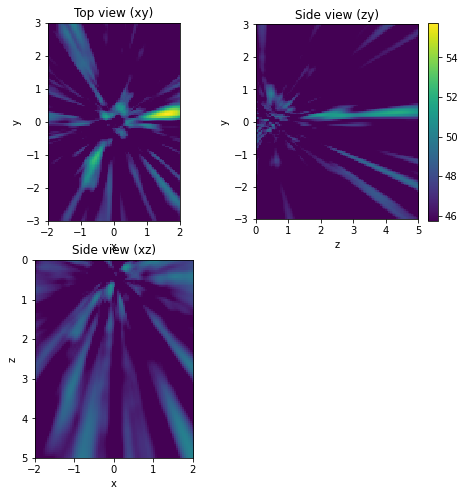

In [87]:
fig=plt.figure(1,(8,8))

# plot the results

plt.subplot(221)
map_z = np.sum(pm,2)
mx = acoular.L_p(map_z.max())
plt.imshow(acoular.L_p(map_z.T), vmax=mx, vmin=mx-10, origin='lower', interpolation='nearest', 
       extent=(rg.x_min, rg.x_max, rg.y_min, rg.y_max))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Top view (xy)' )

plt.subplot(223)
map_y = np.sum(pm,1)
if (rg.y_min == rg.y_max):
       mx = acoular.L_p(map_y.max())
plt.imshow(acoular.L_p(map_y.T), vmax=mx, vmin=mx-10, origin='upper', interpolation='nearest', 
       extent=(rg.x_min, rg.x_max, rg.z_max, rg.z_min))
plt.xlabel('x')
plt.ylabel('z')
plt.title('Side view (xz)' )

plt.subplot(222)
map_x = np.sum(pm,0)
if (rg.x_min == rg.x_max):
       mx = acoular.L_p(map_x.max())
plt.imshow(acoular.L_p(map_x), vmax=mx, vmin=mx-10, origin='lower', interpolation='nearest', 
       extent=(rg.z_min, rg.z_max,rg.y_min, rg.y_max))
plt.xlabel('z')
plt.ylabel('y')
plt.title('Side view (zy)' )
plt.colorbar()

